In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
from copy import deepcopy as dc
import random
from skimage import measure
import geometry_bspline as bsp_geom
import NeuralImplicit as NI
import geometry_visualisation as geom_vis
import geometry_definitions as geom_defs
import network_defs as mod
import SDF
torch.set_default_dtype(torch.float64)

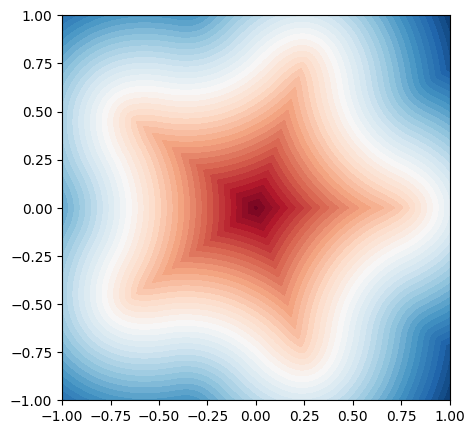

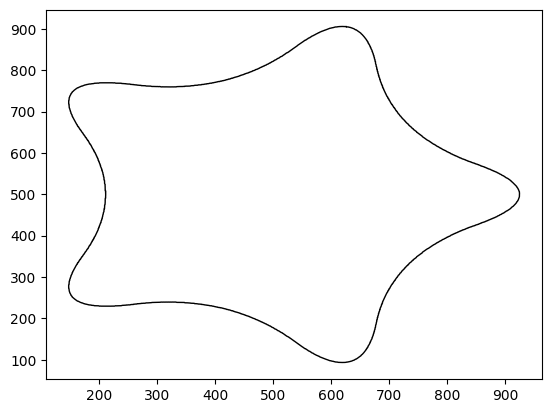

In [3]:
N = 1000                         # grid resolution
x_vals = np.linspace(-1, 1, N)
y_vals = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x_vals, y_vals)

pts = np.stack([X.ravel(), Y.ravel()], axis=1)
pts_t = torch.tensor(pts, dtype=torch.float64)

with torch.no_grad():
    #Z = model(pts_t).cpu().numpy().reshape(N, N)
    rounded_star_cp = geom_defs.create_star_bspline_control_points(center=(0, 0), outer_radius=1.0, inner_radius=0.5, num_star_points=5, degree=2)
    #triangle_cp = geom_defs.create_polygon_bspline_control_points(num_vertices=3, degree=3)
    #L_shape = bsp_geom.create_L_shape_bspline_control_points(1)
    Z = bsp_geom.bspline_signed_distance_vectorized(pts_t, rounded_star_cp, degree=2, use_refinment=False).numpy().reshape(N, N)
    
contours = measure.find_contours(Z, level=0.0)
plt.figure(figsize=(5, 5))
plt.contourf(X, Y, Z, levels=50, cmap='RdBu_r')
plt.show()
for contour in contours:
    plt.plot(contour[:, 1] , contour[:,0] , 'k-', linewidth=1)
plt.show()

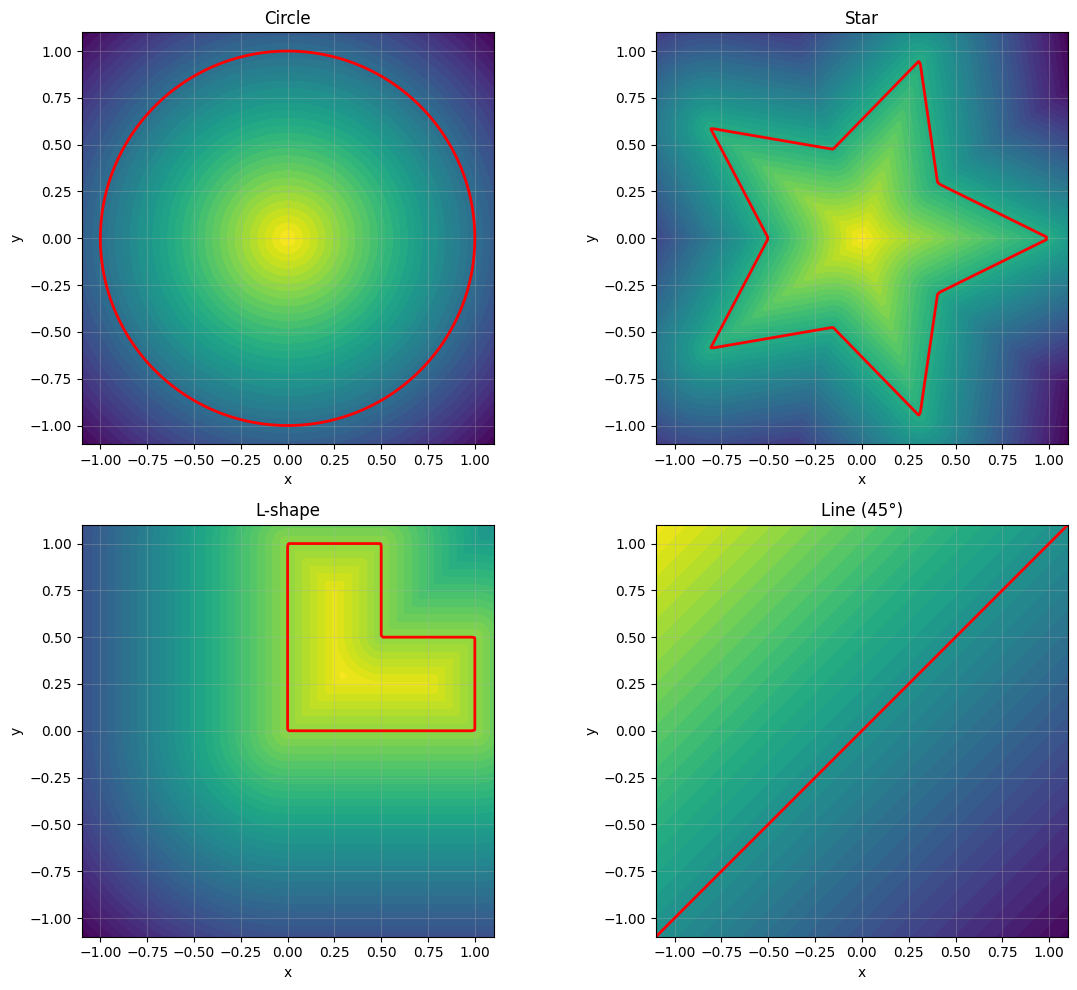

(<Figure size 1200x1000 with 4 Axes>,
 array([<Axes: title={'center': 'Circle'}, xlabel='x', ylabel='y'>,
        <Axes: title={'center': 'Star'}, xlabel='x', ylabel='y'>,
        <Axes: title={'center': 'L-shape'}, xlabel='x', ylabel='y'>,
        <Axes: title={'center': 'Line (45°)'}, xlabel='x', ylabel='y'>],
       dtype=object))

In [3]:
SDF.visualize_all_standard_testcases(N=150, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

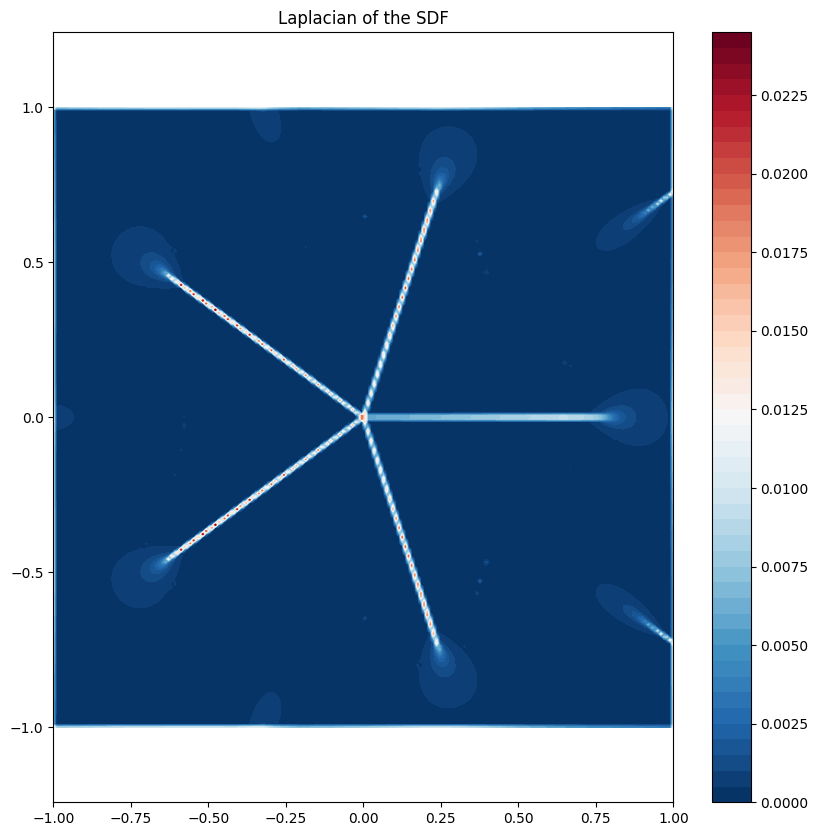

In [4]:
geom_vis.plot_laplacian_of_bspline_sdf(control_points=rounded_star_cp, degree=2, num_samples=6000)

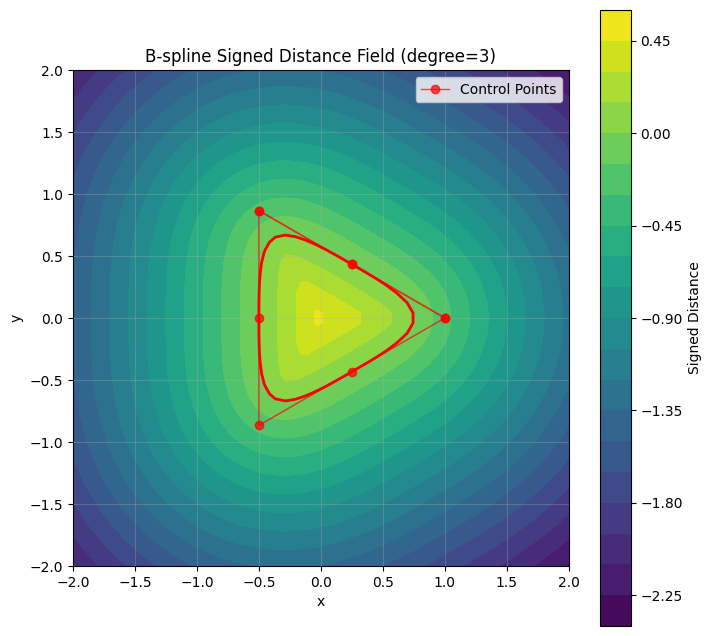

In [2]:
ctrl_pts = geom_defs.create_star_bspline_control_points(center=(0, 0), outer_radius=1.0, inner_radius=0.5, num_star_points=3, degree=3)
#ctrl_pts = geom_defs.create_polygon_bspline_control_points(num_vertices=3, degree=3)
geom_vis.plot_bspline_distance_field(ctrl_pts, degree=3, N=50)

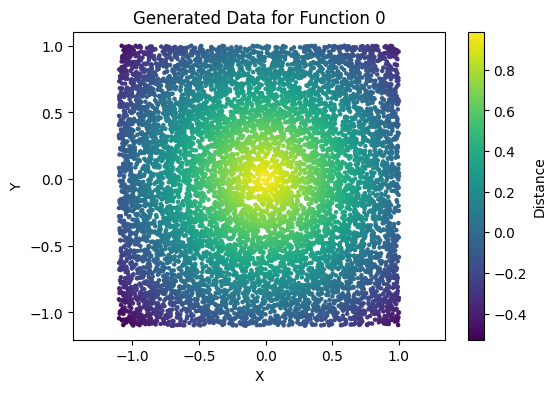

In [2]:
def plot_generated_data(fun_num, num_samples=5000, data_gen_params={}):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #coordinates, distances = NI.generate_bspline_data(num_samples,fun_num, device=device, data_gen_params=data_gen_params)
    coordinates, distances = NI.generate_data(num_samples=num_samples,fun_num=fun_num, device=device, data_gen_params=data_gen_params)
    coordinates = coordinates.cpu().numpy()
    distances = distances.cpu().numpy()

    plt.figure(figsize=(6, 4))
    sc = plt.scatter(coordinates[:, 0], coordinates[:, 1], c=distances[:, 0], cmap='viridis', s=5)
    plt.colorbar(sc, label='Distance')
    plt.title(f'Generated Data for Function {fun_num}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('equal')
    plt.show()
plot_generated_data(fun_num=0, num_samples=10000, data_gen_params={"num_star_points":3, "degree":3})

In [ ]:
NI.plot_model_weight_per_layer_hyst(model)

In [ ]:
def train_model(model,num_epochs=10):
    report_interval = num_epochs // 10
    criterion = nn.MSELoss()
    star_cp = bsp_geom.create_star_bspline_control_points(center=(0, 0), outer_radius=1.0, inner_radius=0.5, num_star_points=5, degree=1)
    knots = bsp_geom.create_knot_vector(len(star_cp), degree=1)
    L_EIKON = 1e3
    L_BND = 1e4
    L_BND_GRAD = 1e1
    L_XI = 3e2
    NUM_POINTS = 1000
    for epoch in range(num_epochs):
        star_cp = bsp_geom.create_star_bspline_control_points(center=(0, 0), outer_radius=1.0, inner_radius=0.5, num_star_points=5, degree=1)
        boundary_pts, t_values = bsp_geom.generate_points_on_curve(star_cp, num_points=NUM_POINTS, degree=1, device=None, return_t=True)
        other_pts = torch.randn((NUM_POINTS,2))*2-1
        other_pts = other_pts.clone().detach().requires_grad_(True)
        pred_other = model(other_pts)
        grds = torch.autograd.grad(outputs=pred_other, inputs=other_pts, grad_outputs=torch.ones_like(pred_other),retain_graph=True, allow_unused=True, create_graph=True)
        eikonloss = torch.sum(grds[0]**2,dim=1)
        eikonloss_output = torch.abs(1-torch.sqrt(eikonloss)).mean()
        boundary_pts = boundary_pts.clone().detach().requires_grad_(True)
        bond_normal = bsp_geom.bspline_normalvectors(t_values,star_cp,knots,degree=1)
        # elementwise scalar product of bond_normal and gradient of pred_boundary
        pred_boundary = model(boundary_pts)
        grds_boundary = torch.autograd.grad(outputs=pred_boundary, inputs=boundary_pts, grad_outputs=torch.ones_like(pred_boundary),retain_graph=True, allow_unused=True, create_graph=True)
        #print(grds_boundary)
        scalar_prods = torch.sum(grds_boundary[0] * bond_normal, dim=1)
        scalar_loss = torch.abs(1- scalar_prods).mean()
        loss_boundary = torch.abs(torch.mean(torch.abs(pred_boundary)))
        loss_xi = torch.mean(torch.exp(-100*torch.abs(pred_other)))
        loss = L_BND*loss_boundary + L_EIKON*eikonloss_output + L_XI*loss_xi + L_BND_GRAD*scalar_loss
        model.optimizer.zero_grad()
        loss.backward()
        model.optimizer.step()
        model.lr_scheduler.step()
        model.loss_history.append(loss.item())
        if epoch % report_interval == 0:
            CALCULATE_ERROR = False
            if CALCULATE_ERROR:
                pts = torch.randn((5000,2))*2-1
                with torch.no_grad():
                    pred = model(pts)
                    star_sdf = bsp_geom.bspline_signed_distance_vectorized(pts,star_cp,degree=1)
                    error = criterion(pred.squeeze(), star_sdf)
                print(f"Epoch {epoch}, Loss: {loss.item():.6f}, SDF Error: {error.item():.6f}")
                print(f"Losses: Boundary: {L_BND*loss_boundary.item():.6f}, Eikonal: {L_EIKON*eikonloss_output.item():.6f}, Xi: {L_XI*loss_xi.item():.6f}, Scalar prod: {L_BND_GRAD*scalar_loss.item():.6f}")
            else:
                print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
            
train_model(model,100)

In [20]:
#Test calc accuracy
pts = torch.randn((10000,2))*2-1
DEGREE = 2
high_res = bsp_geom.bspline_signed_distance_vectorized(pts, rounded_star_cp, degree=DEGREE, num_curve_samples=60000)
low_res = bsp_geom.bspline_signed_distance_vectorized(pts, rounded_star_cp, degree=DEGREE, num_curve_samples=6000)
error = torch.abs(high_res - low_res)
print(f"SDF MAE between 60000 and 6000 samples: {torch.mean(error).item():}")


SDF MAE between 60000 and 6000 samples: 2.1292987225185537e-07


In [78]:

architecture = [2,256,256,256,1]
model1 = mod.Siren(architecture, outermost_linear=True, first_omega_0=60, hidden_omega_0=60)
model2 = mod.PE_Relu(architecture=[2,256,256,256,256,1], num_freqs=5)
model3 = mod.NeuralNetwork(architecture=[2,256,256,256,256,1])

print(f"number of parameters: {sum(p.numel() for p in model1.parameters() if p.requires_grad)}")
print(f"number of parameters: {sum(p.numel() for p in model2.parameters() if p.requires_grad)}")
print(f"number of parameters: {sum(p.numel() for p in model3.parameters() if p.requires_grad)}")

model1.optimizer = torch.optim.Adam(lr=1e-5, params=model1.parameters())
model2.optimizer = torch.optim.Adam(lr=1e-5, params=model2.parameters())
model3.optimizer = torch.optim.Adam(lr=1e-5, params=model3.parameters())


#model.lr_scheduler = torch.optim.lr_scheduler.StepLR(model.optimizer, step_size=1000, gamma=0.8)
model1.lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(model1.optimizer, T_max=10000, eta_min=1e-8)
model2.lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(model2.optimizer, T_max=10000, eta_min=1e-8)
model3.lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(model3.optimizer, T_max=10000, eta_min=1e-8)

# SIREN 198k parameters - Adam - 1e-6 
# ReLU 189k parameters - Adam - 1e-6

number of parameters: 198401
number of parameters: 203521
number of parameters: 198401


In [ ]:
# OPEN existing model
model2 = mod.load_model( model2,"PE_RELU_198000_rnd_star_bt150_importance_0_bnd_1.pth")

c:\Egyetem\Kutatás\NeuralIGA\Neural iga\NeuralSDF\network_defs.py:435: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


In [79]:

DEGREE = 2
NI.train_models_with_extras([model1,model2,model3],num_epochs = 10000, batch_size = 1500, fun_num=0, 
                            gt_num_curve_samples=6000,
                            data_gen_params={"num_star_points":5, "degree":DEGREE},
                            data_gen_mode='standard',
                            eikon_coeff=0.0, boundry_coeff=0, 
                            evaluation_coeff=1,
                            use_scheduler = True,
                            crt = nn.MSELoss(),
                            create_error_distribution_hystory=False,error_distribution_resolution=100, 
                            create_SDF_history=False, hytory_after_epochs=200,
                            use_importance_sampling=False, importance_sampling_coeff=0.0,
                            use_refinement=None
                            )


Epoch [0], Losses: SIREN: 0.11503574169299702, PE_ReLU: 0.11507061962894727, ReLU: 0.113105736575396
Epoch [999], Losses: SIREN: 2.3451204595968175e-05, PE_ReLU: 0.00028697983362585284, ReLU: 0.00021515155494365867
Epoch [1999], Losses: SIREN: 3.2940135421765474e-06, PE_ReLU: 6.176434739923273e-05, ReLU: 3.292730089817346e-05
Epoch [2999], Losses: SIREN: 4.434395388507551e-06, PE_ReLU: 3.1236681490184926e-05, ReLU: 1.1538630815493832e-05
Epoch [3999], Losses: SIREN: 2.8939633101303976e-06, PE_ReLU: 1.9023909976441317e-05, ReLU: 4.849974637016263e-06
Epoch [4999], Losses: SIREN: 2.3048722240396693e-06, PE_ReLU: 1.1815830332176413e-05, ReLU: 2.83139470694939e-06
Epoch [5999], Losses: SIREN: 5.784767233205493e-07, PE_ReLU: 9.534054862086008e-06, ReLU: 2.1498978191102987e-06
Epoch [6999], Losses: SIREN: 3.310861730325503e-07, PE_ReLU: 7.686724626491461e-06, ReLU: 1.603304994657876e-06
Epoch [7999], Losses: SIREN: 1.9055998898779655e-07, PE_ReLU: 6.350578230615505e-06, ReLU: 1.4277644859886

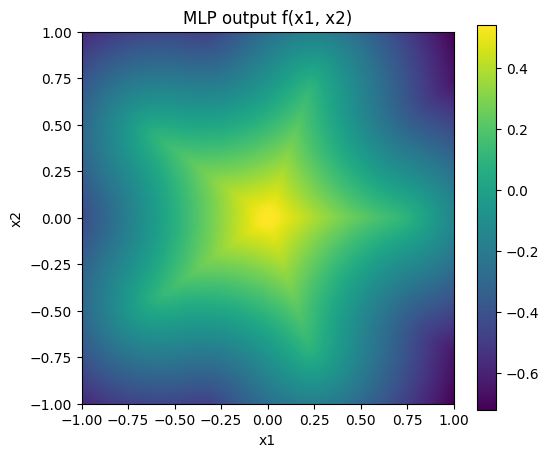

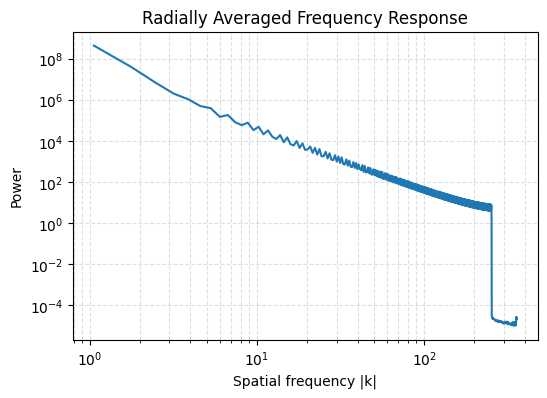

In [47]:
N = 1014                         # grid resolution
x_vals = np.linspace(-1, 1, N)
y_vals = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x_vals, y_vals)

pts = np.stack([X.ravel(), Y.ravel()], axis=1)
pts_t = torch.tensor(pts, dtype=torch.float64)

with torch.no_grad():
    Z = model(pts_t).cpu().numpy().reshape(N, N)
    #rounded_star_cp = bsp_geom.create_star_bspline_control_points(center=(0, 0), outer_radius=1.0, inner_radius=0.5, num_star_points=5, degree=2)
    #L_shape = bsp_geom.create_L_shape_bspline_control_points(1)
    #Z = bsp_geom.bspline_signed_distance_vectorized(pts_t, rounded_star_cp, degree=2).numpy().reshape(N, N)
# ------------------------------------------------------------
# 3. Plot the output f(x)
# ------------------------------------------------------------
plt.figure(figsize=(6,5))
plt.imshow(Z, extent=[-1,1,-1,1], origin='lower')
plt.title("MLP output f(x1, x2)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar()
plt.show()

# ------------------------------------------------------------
# 4. Compute 2D FFT (frequency response)
# ------------------------------------------------------------
F = np.fft.fftshift(np.fft.fft2(Z))
power = np.abs(F)**2

# Frequency axes
freq_x = np.fft.fftshift(np.fft.fftfreq(N, d=(x_vals[1]-x_vals[0])))
freq_y = np.fft.fftshift(np.fft.fftfreq(N, d=(y_vals[1]-y_vals[0])))

FX, FY = np.meshgrid(freq_x, freq_y)
radial_freq = np.sqrt(FX**2 + FY**2).ravel()

# ------------------------------------------------------------
# 5. Radially averaged power spectrum
# ------------------------------------------------------------
nbins = N // 2
bins = np.linspace(0, radial_freq.max(), nbins+1)
radial_power = np.zeros(nbins)
counts = np.zeros(nbins)

bin_index = np.digitize(radial_freq, bins) - 1
flat_power = power.ravel()

for i, p in enumerate(flat_power):
    k = bin_index[i]
    if 0 <= k < nbins:
        radial_power[k] += p
        counts[k] += 1

radial_power /= np.maximum(1, counts)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ------------------------------------------------------------
# 6. Plot frequency response
# ------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.loglog(bin_centers[1:], radial_power[1:])
plt.title("Radially Averaged Frequency Response")
plt.xlabel("Spatial frequency |k|")
plt.ylabel("Power")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.show()

MovieWriter imagemagick unavailable; using Pillow instead.


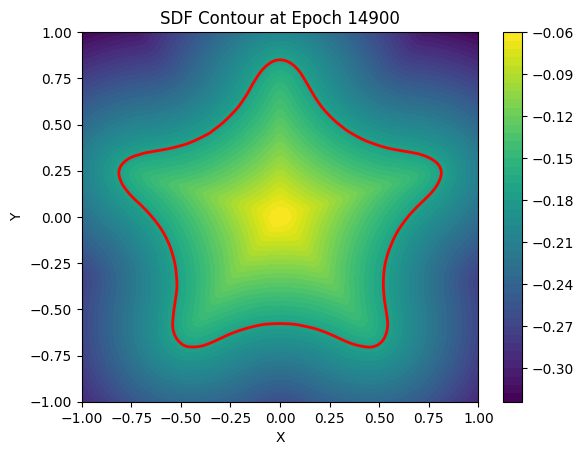

In [ ]:
NI.create_animation_SDF_contourf(model, interval=500, save_path="SDF_evolution_ReLU_cos_rnd_trg.gif", skip_initial_frames=0, adaptive_scaling=False, plot_cntr = True)

In [53]:
!ffmpeg -i error_anim_normal_sched_cos.gif -movflags faststart -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" error_anim_normal_sched_cos.mp4


ffmpeg version 8.0.1-full_build-www.gyan.dev Copyright (c) 2000-2025 the FFmpeg developers
  built with gcc 15.2.0 (Rev8, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-lcms2 --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-libsnappy --enable-zlib --enable-librist --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-libdvdnav --enable-libdvdread --enable-sdl2 --enable-libaribb24 --enable-libaribcaption --enable-libdav1d --enable-libdavs2 --enable-libopenjpeg --enable-libquirc --enable-libuavs3d --enable-libxevd --enable-libzvbi --enable-liboapv --enable-libqrencode --enable-librav1e --enable-libsvtav1 --enable-libvvenc --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs2 --enable-libxeve --enable-libxvid --enable-libaom --enable-libjxl --enable-libvpx --

MovieWriter imagemagick unavailable; using Pillow instead.


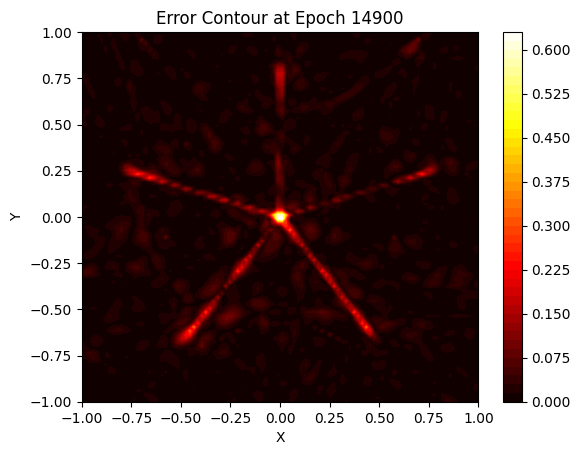

In [51]:
NI.create_animation_error_contourf(model, interval= 500,save_path="error_anim_ReLU_cos.gif",skip_initial_frames=0, adaptive_scaling=True, plot_cntr = False)

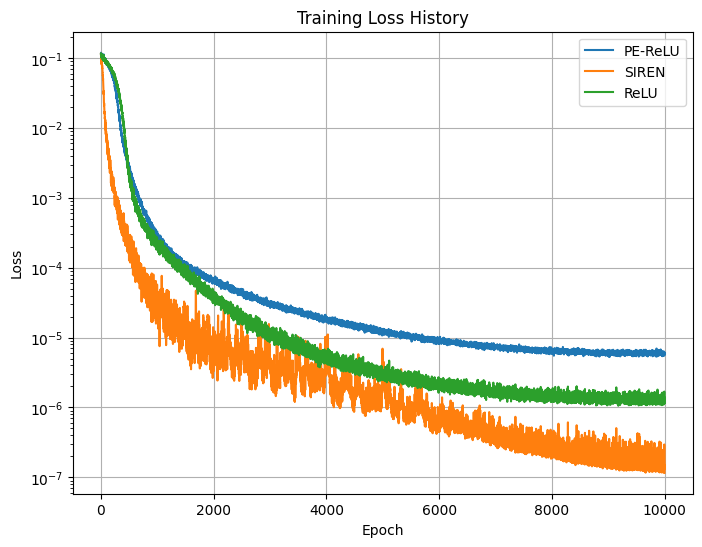

In [80]:
#plot loss history
plt.figure(figsize=(8, 6))
plt.plot(model2.loss_history)
plt.plot(model1.loss_history)
plt.plot(model3.loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.grid(True)
plt.yscale('log')
plt.legend(['PE-ReLU','SIREN','ReLU'])
plt.show()

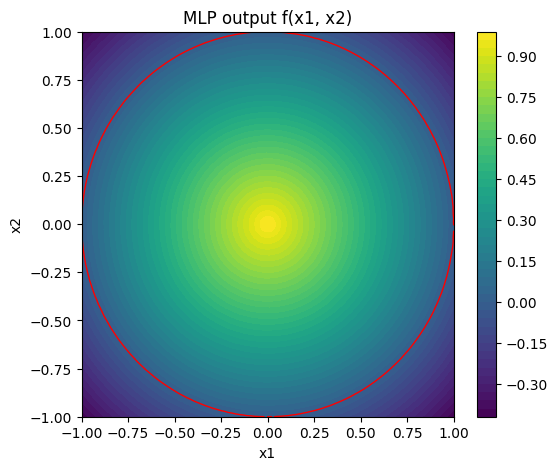

In [82]:
# plot model output 
N=100
x_vals = np.linspace(-1, 1, N)
y_vals = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x_vals, y_vals)
Z = model1(torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=1), dtype=torch.float64)).cpu().detach().numpy().reshape(N, N)
plt.figure(figsize=(6,5))
#plot contourf
plt.contourf(X, Y, Z, levels=50)
#plot zero level contour
plt.colorbar()
plt.contour(X, Y, Z, levels=[0], colors='r', linewidths=1)

plt.title("MLP output f(x1, x2)")
plt.xlabel("x1")
plt.ylabel("x2")

plt.show()

In [87]:
#ALTERNATIVE contour error
DEGREE = 2
mdl = model3
#rounded_star_cp = geom_defs.create_star_bspline_control_points(center=(0, 0), outer_radius=1.0, inner_radius=0.5, num_star_points=5, degree=DEGREE)
#pts = NI.generate_bspline_boundary_points(num_boundary_points=6000, case=3, data_gen_params={"num_star_points":5, "degree":2})
pts = NI.generate_standard_boundary_points(num_boundary_points=6000, fun_num=0)
with torch.no_grad():
    pred_sdf = mdl(pts).cpu().numpy()
alt_bnd_mae = np.mean(np.abs(pred_sdf))
print(f"Alternative boundary MAE: {alt_bnd_mae}")
alt_bnd_max_err = np.max(np.abs(pred_sdf))
print(f"Alternative boundary Max Error: {alt_bnd_max_err}")
#GT 
gt_sdf = 1 - torch.sqrt(pts[:,0]**2 + pts[:,1]**2).numpy()
gt_bnd_mae = np.mean(np.abs(gt_sdf))
print(f"GT boundary MAE: {gt_bnd_mae}")
#model error
pts,target = NI.generate_data(10000, fun_num=0)
with torch.no_grad():
    pred = mdl(pts)
    error = torch.abs(target.squeeze() - pred.squeeze())
    mae = torch.mean(error).item()
    max_err = torch.max(error).item()
print(f"Model MAE: {mae}")
print(f"Model Max Error: {max_err}")

Alternative boundary MAE: 0.0008133676126546877
Alternative boundary Max Error: 0.0032379293041504623
GT boundary MAE: 1.0732155904709847e-18
Model MAE: 0.0008291092443524509
Model Max Error: 0.010424310626871991


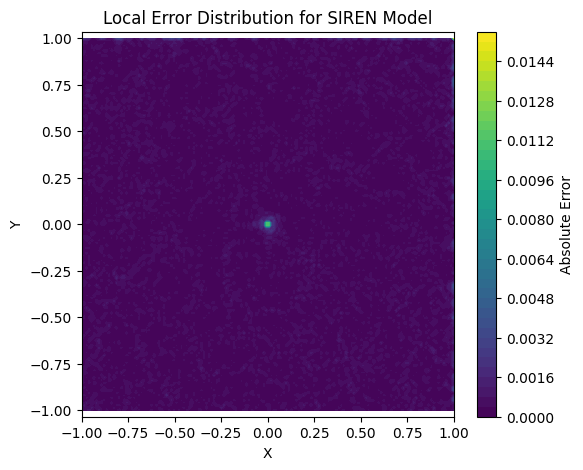

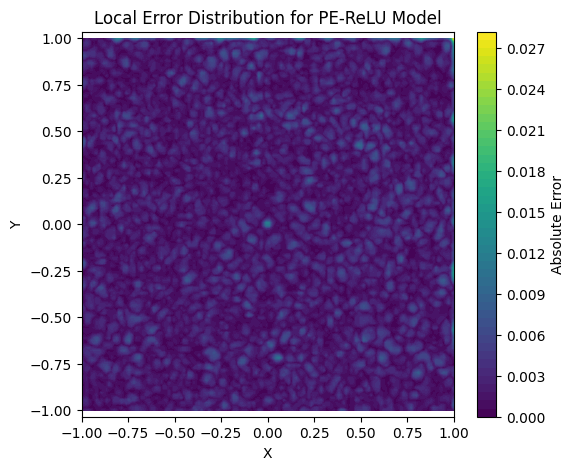

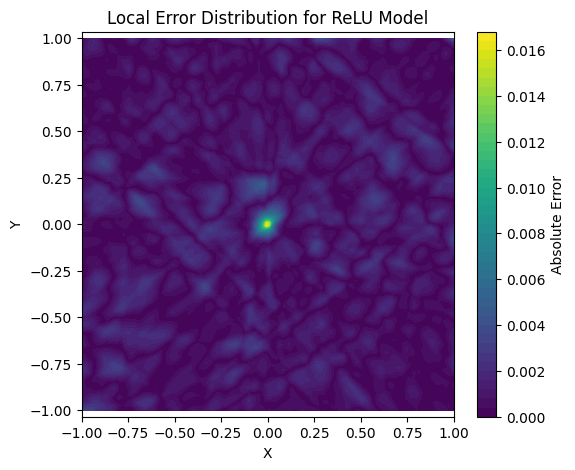

In [91]:
# plot local distribution of errors
model_list = [model1, model2, model3]
model_names = ['SIREN', 'PE-ReLU', 'ReLU']
for i in range(len(model_list)):
    model = model_list[i]
    name = model_names[i]
    x_vals = np.linspace(-1, 1, 150)
    y_vals = np.linspace(-1, 1, 150)
    X, Y = np.meshgrid(x_vals, y_vals)
    pts = torch.tensor(np.vstack([X.ravel(), Y.ravel()]).T, dtype=torch.float64)
    target = 1 - torch.sqrt(pts[:,0]**2 + pts[:,1]**2)
    with torch.no_grad():
        pred = model(pts)
        error = torch.abs(target.squeeze() - pred.squeeze()).cpu().numpy()
    #create scatter plot of pts colored by error
    plt.figure(figsize=(6, 5))
    #contourf
    sc = plt.contourf(X, Y, error.reshape(X.shape), levels=50,  cmap='viridis')
    #set to log scale for colorbar
    
    plt.colorbar(sc, label='Absolute Error')
    #zero level contour
    plt.contour(X, Y, error.reshape(X.shape), levels=[0], colors='r', linewidths=1)
    plt.title(f'Local Error Distribution for {name} Model')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('equal')
    plt.show()

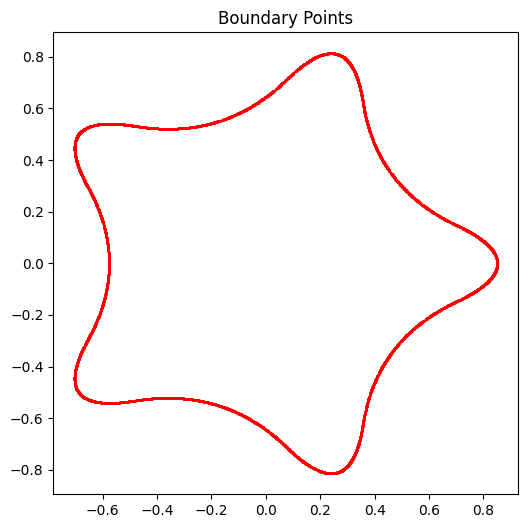

In [8]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(pts[:,0].cpu().numpy(), pts[:,1].cpu().numpy(), 'ro', markersize=1)
ax.set_title("Boundary Points")
plt.show()

In [94]:
torch.save(model3.state_dict(), 'RELU_198000_circle_case4.pth')

In [39]:
geom_vis.plot_laplacian_of_bspline_sdf(model=model1,num_samples=6000, control_points=rounded_star_cp, degree=DEGREE)

NameError: name 'rounded_star_cp' is not defined

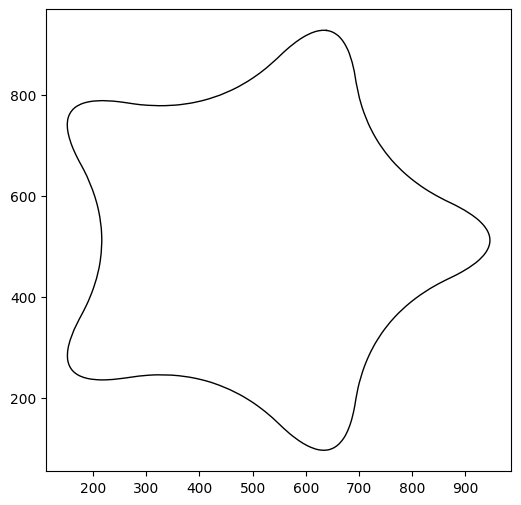

In [9]:
N = 1024                        # grid resolution
x_vals = np.linspace(-1, 1, N)
y_vals = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x_vals, y_vals)
pts = np.stack([X.ravel(), Y.ravel()], axis=1)
pts_t = torch.tensor(pts, dtype=torch.float64)

with torch.no_grad():
    Z = model2(pts_t).cpu().numpy().reshape(N, N)
    rounded_star_cp = geom_defs.create_star_bspline_control_points(center=(0, 0), outer_radius=1.0, inner_radius=0.5, num_star_points=5, degree=DEGREE)
    #L_shape = bsp_geom.create_L_shape_bspline_control_points(1)
    #Z2 = bsp_geom.bspline_signed_distance_vectorized(pts_t, rounded_star_cp, degree=DEGREE,num_curve_samples=6000).numpy().reshape(N, N)
contours = measure.find_contours(Z, level=0.0)
# convert to [-1,1,-1,1]
contours_red = contours
#contours2  = measure.find_contours(Z2, level=0.0)
fig, ax = plt.subplots(figsize=(6, 6))
#ax.contourf(X, Y, Z2, levels=50, cmap='RdBu_r')
for contour in contours:
    ax.plot(contour[:, 1] , contour[:,0] , 'k-', linewidth=1)
#for contour in contours2:
#    ax.plot(contour[:, 1] , contour[:,0] , 'r--', linewidth=1)
plt.show()

C:\Users\csapo\AppData\Local\Temp\ipykernel_5608\1090264264.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  contours_t = torch.tensor(contours, dtype=torch.float64).reshape(-1,2)


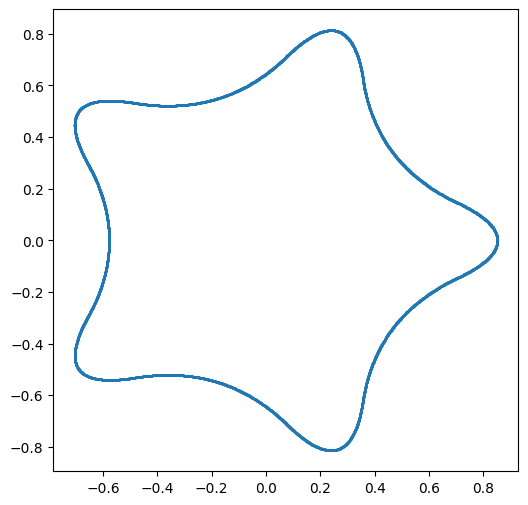

tensor(0.0773)


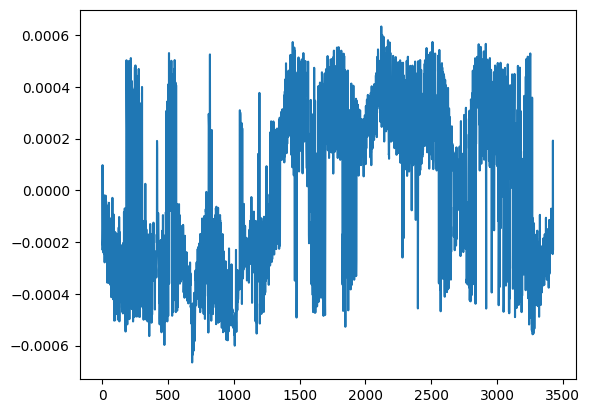

In [10]:
import geometry_definitions as geom_defs
rounded_star_cp = geom_defs.create_star_bspline_control_points(center=(0, 0), outer_radius=1.0, inner_radius=0.5, num_star_points=5, degree=DEGREE)
#convert contours to torch tensor
contours_t = torch.tensor(contours, dtype=torch.float64).reshape(-1,2)
contours_t = contours_t.flip(1)
#contourst2  = torch.tensor(contours2, dtype=torch.float64).reshape(-1,2)
#contourst2 = contourst2.flip(1)
contours_t = 2*(contours_t/(N-1))-1
# contourst2 = 2*(contourst2/(N-1))-1 
plt.figure(figsize=(6,6))
plt.scatter(contours_t[:,0],contours_t[:,1],s=1)
#plt.scatter(contourst2[:,0],contourst2[:,1],s=1)
plt.show()
#normalize contours_t to [-1,1]x[-1,1]
#print(contours_t)
contour_error = bsp_geom.bspline_signed_distance_vectorized(query_points=contours_t,control_points=rounded_star_cp, degree=DEGREE,num_curve_samples=6000)
#contourst2_error = bsp_geom.bspline_signed_distance_vectorized(query_points=contourst2,control_points=rounded_star_cp, degree=DEGREE,num_curve_samples=6000)
print(bsp_geom.bspline_signed_distance_vectorized(query_points=torch.tensor([-0.5,-0]),control_points=rounded_star_cp, degree=DEGREE,num_curve_samples=6000))
plt.plot(contour_error.numpy())
#plt.plot(contourst2_error.numpy())

In [11]:
print("PE_ReLU with 100000 steps 300 batch size, importance sampleing 0 sigma 0.01 MSE Error:")
contour_error_mae = torch.mean(torch.abs(contour_error))
print(f"Contour MAE: {contour_error_mae.item():.6f}")
contour_error_L2 = torch.mean(contour_error**2)
print(f"Contour L2 Error: {contour_error_L2.item()}")
contour_error_std = torch.std(contour_error)
print(f"Contour Error Std Dev: {contour_error_std.item():.6f}")
contour_error_max = torch.max(torch.abs(contour_error))
print(f"Contour Max Error: {contour_error_max.item():.6f}")
# model error
with torch.no_grad():
    pts, target = NI.generate_bspline_data(num_samples=5000, case=3, data_gen_params={"num_star_points":5, "degree":DEGREE},gt_num_curve_samples=6000)
    model_pred = model2(pts)
    model_error = torch.abs(model_pred - target)
    model_error_mae = torch.mean(model_error)
    model_error_L2 = torch.mean(model_error**2)
    model_error_std = torch.std(model_error)
    model_error_max = torch.max(model_error)
    print(f"Model MAE: {model_error_mae.item():.6f}")
    print(f"Model L2 Error: {model_error_L2.item()}")
    print(f"Model Error Std Dev: {model_error_std.item():.6f}")
    print(f"Model Max Error: {model_error_max.item():.6f}")

PE_ReLU with 100000 steps 300 batch size, importance sampleing 0 sigma 0.01 MSE Error:
Contour MAE: 0.000276
Contour L2 Error: 9.329717915638439e-08
Contour Error Std Dev: 0.000305
Contour Max Error: 0.000666
Model MAE: 0.000414
Model L2 Error: 2.823763468632663e-07
Model Error Std Dev: 0.000334
Model Max Error: 0.003856


In [12]:
contour_error_mae = torch.mean(torch.abs(contourst2_error))
print(f"Contour MAE: {contour_error_mae.item():.6f}")
contour_error_L2 = torch.mean(contourst2_error**2)
print(f"Contour L2 Error: {contour_error_L2.item():.6f}")
contour_error_std = torch.std(contourst2_error)
print(f"Contour Error Std Dev: {contour_error_std.item():.6f}")
contour_error_max = torch.max(torch.abs(contourst2_error))
print(f"Contour Max Error: {contour_error_max.item():.6f}")

NameError: name 'contourst2_error' is not defined

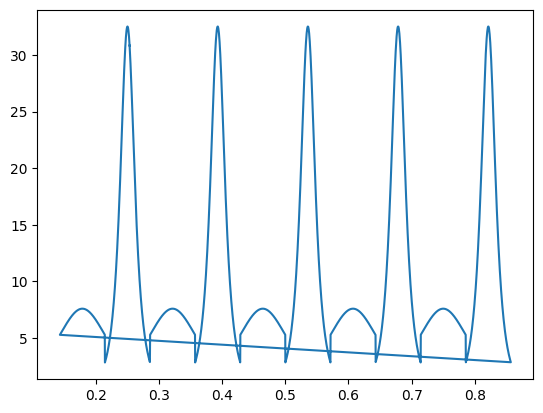

In [13]:
# plot curvature of B-spline curve at parameter values t.
t_values_conv = contours_t#.squeeze(0) # dummy conversion, replace with actual parameter values if available
#replacing x and y in t_values_conv

t_values = []

for i in range(t_values_conv.shape[0]):
    t_val = bsp_geom.find_closest_point_on_bspline_curve(query_point=t_values_conv[i], control_points=rounded_star_cp, degree=DEGREE, num_curve_samples=6000)
    t_values.append(t_val)
t_values = torch.tensor(t_values, dtype=torch.float64)

knots = bsp_geom.create_knot_vector(len(rounded_star_cp), degree=DEGREE, closed=True)
curvatures = bsp_geom.bspline_curvature(t_values, rounded_star_cp,knots=knots, degree=DEGREE)
plt.plot(t_values.numpy(),curvatures.numpy())

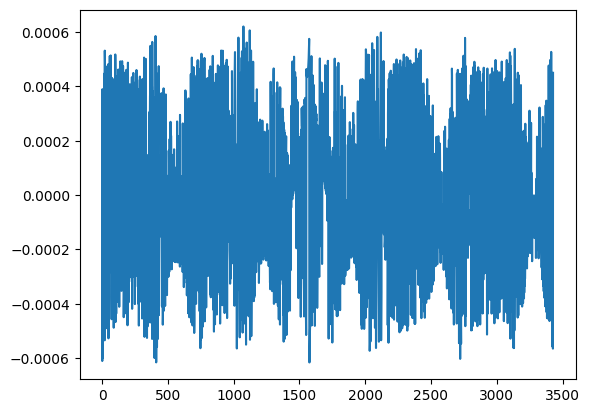

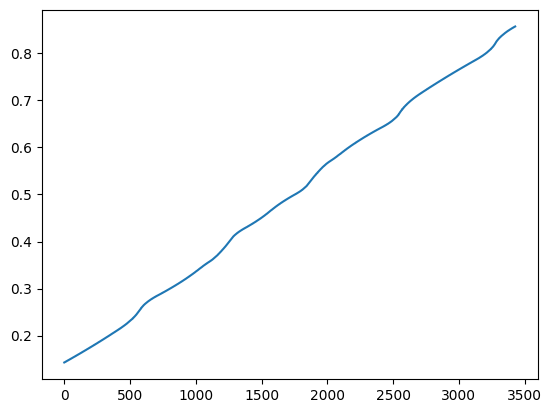

In [78]:
# GT
t_values_2 = contourst2
t_values2 = []
for i in range(t_values_2.shape[0]):
    t_val2 = bsp_geom.find_closest_point_on_bspline_curve(query_point=t_values_2[i], control_points=rounded_star_cp, degree=DEGREE, num_curve_samples=6000)
    t_values2.append(t_val2)
t_values2 = torch.tensor(t_values2, dtype=torch.float64)

t_values_sorted_2, indices = torch.sort(t_values2)
contour_error_sorted2 = contourst2_error[indices]
curvatures_2 = bsp_geom.bspline_curvature(t_values_sorted_2, rounded_star_cp,knots=knots, degree=DEGREE)
plt.plot(contour_error_sorted2.numpy())
plt.show()
plt.plot(t_values_sorted_2.numpy())
plt.show()


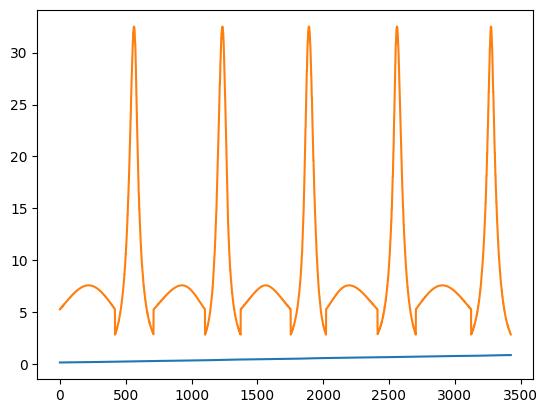

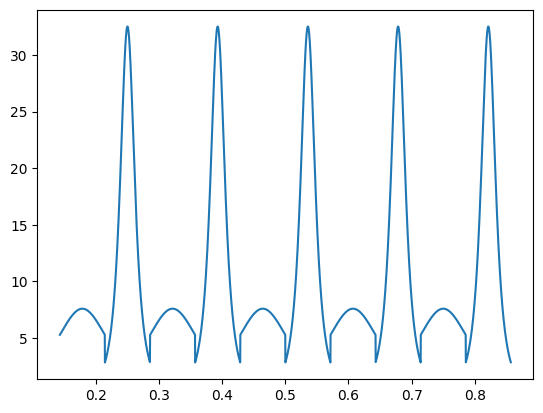

In [14]:


t_values_sorted, indices = torch.sort(t_values)
curvatures_sorted = curvatures[indices]
contour_error_sorted = contour_error[indices]
plt.plot(t_values_sorted.numpy())
plt.plot(curvatures_sorted.numpy())
plt.figure()
plt.plot(t_values_sorted.numpy(), curvatures_sorted.numpy())

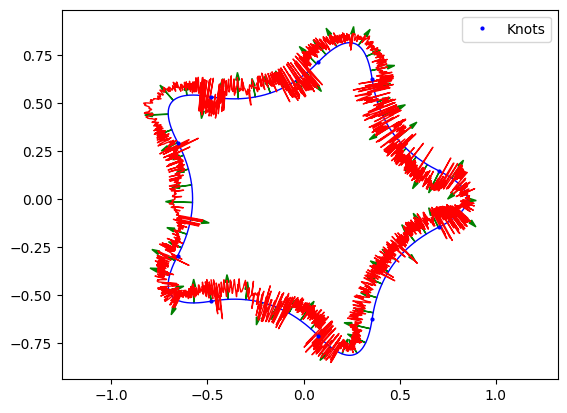

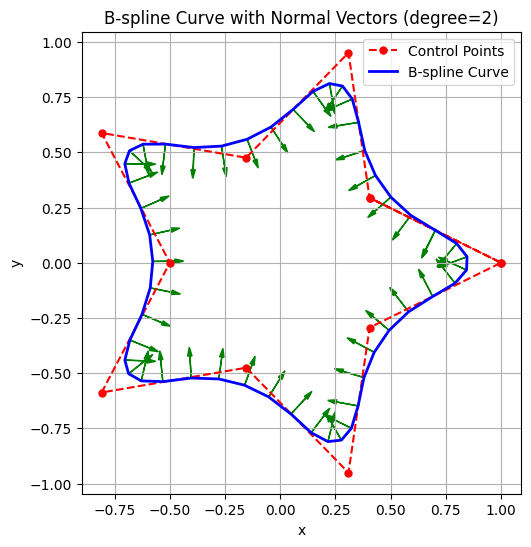

In [15]:
# plot curvature onto the contour plot
# ------------------------------------------------------------

fig, ax = plt.subplots()
#ax.contourf(X, Y, Z, levels=50, cmap='RdBu_r')
magnitude = 200

normal_vec = bsp_geom.bspline_normalvectors(t=t_values, control_points=rounded_star_cp,knots=bsp_geom.create_knot_vector(rounded_star_cp.shape[0], degree=DEGREE, closed=True), degree=DEGREE)
new_point = np.zeros_like(contours_t.numpy())

tmp = bsp_geom.evaluate_bspline_curve_vectorized(t_values, rounded_star_cp, bsp_geom.create_knot_vector(rounded_star_cp.shape[0], degree=DEGREE, closed=True), degree=DEGREE)
ax.plot(tmp[:,0] , tmp[:,1] , 'b-',  linewidth=1)

for i in range(len(contours_t)):
    new_point[i] = tmp[i] + normal_vec[i].numpy()*magnitude*contour_error[i].numpy()
    if i % 50 == 0:
        start = tmp[i].numpy()
        err = contour_error[i].numpy()
        ax.arrow(start[0], start[1], normal_vec[i, 0].numpy()*err*magnitude, normal_vec[i, 1].numpy()*err*magnitude,
                  head_width=0.02, head_length=0.04, fc='g', ec='g')
               
ax.plot(new_point[:,0] , new_point[:,1] , 'r-',  linewidth=1)
#also mark the knots
knots = bsp_geom.create_knot_vector(len(rounded_star_cp), degree=DEGREE, closed=True)
knot_points = bsp_geom.evaluate_bspline_curve_vectorized(knots, rounded_star_cp, knots, degree=DEGREE)[DEGREE:-DEGREE-1]
ax.plot(knot_points[:,0], knot_points[:,1], 'bo', markersize=2, label='Knots')
ax.legend()
ax.axis('equal')
geom_vis.plot_normal_vectors_on_bspline(rounded_star_cp, degree=DEGREE, num_vectors=50, vector_length=0.1)
    



plt.show()



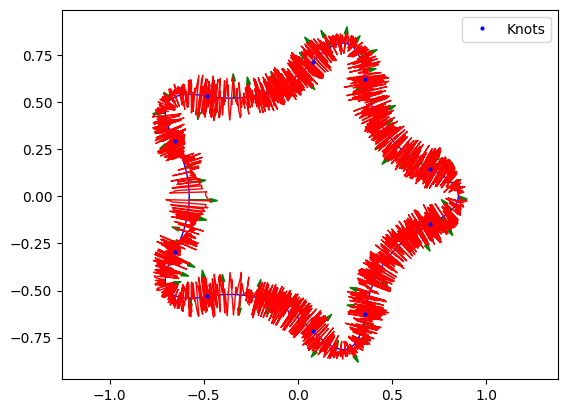

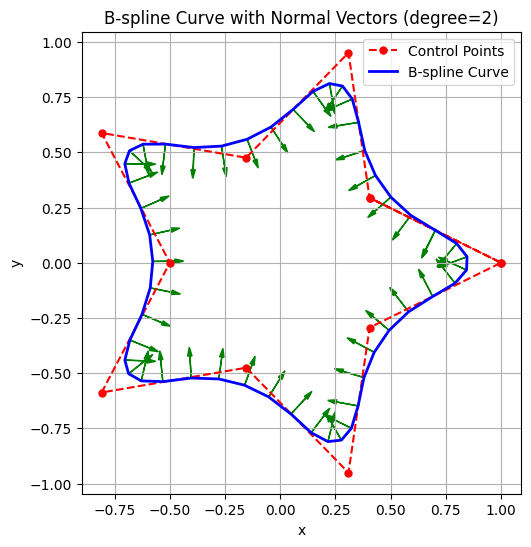

In [77]:
# plot GT ERROR
# ------------------------------------------------------------

fig, ax = plt.subplots()
#ax.contourf(X, Y, Z, levels=50, cmap='RdBu_r')
magnitude = 200

normal_vec = bsp_geom.bspline_normalvectors(t=t_values2, control_points=rounded_star_cp,knots=bsp_geom.create_knot_vector(rounded_star_cp.shape[0], degree=DEGREE, closed=True), degree=DEGREE)
new_point = np.zeros_like(contourst2.numpy())

tmp = bsp_geom.evaluate_bspline_curve_vectorized(t_values2, rounded_star_cp, bsp_geom.create_knot_vector(rounded_star_cp.shape[0], degree=DEGREE, closed=True), degree=DEGREE)
ax.plot(tmp[:,0] , tmp[:,1] , 'b-',  linewidth=1)

for i in range(len(contourst2)):
    new_point[i] = tmp[i] + normal_vec[i].numpy()*magnitude*contourst2_error[i].numpy()
    if i % 50 == 0:
        start = tmp[i].numpy()
        err = contourst2_error[i].numpy()
        ax.arrow(start[0], start[1], normal_vec[i, 0].numpy()*err*magnitude, normal_vec[i, 1].numpy()*err*magnitude,
                  head_width=0.02, head_length=0.04, fc='g', ec='g')
               
ax.plot(new_point[:,0] , new_point[:,1] , 'r-',  linewidth=1)
#also mark the knots
knots = bsp_geom.create_knot_vector(len(rounded_star_cp), degree=DEGREE, closed=True)
knot_points = bsp_geom.evaluate_bspline_curve_vectorized(knots, rounded_star_cp, knots, degree=DEGREE)[DEGREE:-DEGREE-1]
ax.plot(knot_points[:,0], knot_points[:,1], 'bo', markersize=2, label='Knots')
ax.legend()
ax.axis('equal')
geom_vis.plot_normal_vectors_on_bspline(rounded_star_cp, degree=DEGREE, num_vectors=50, vector_length=0.1)
    



plt.show()



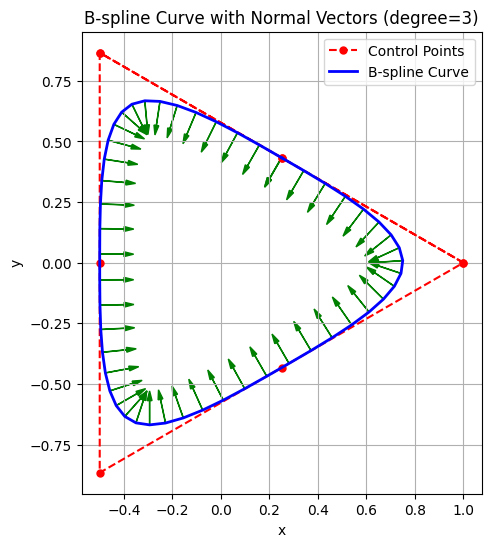

In [126]:
#experimental bspline shapes
cntr_pts = geom_defs.create_star_bspline_control_points(center=(0, 0), outer_radius=1.0, inner_radius=0.5, num_star_points=3, degree=3)
geom_vis.plot_normal_vectors_on_bspline(cntr_pts, degree=3, num_vectors=50, vector_length=0.1)

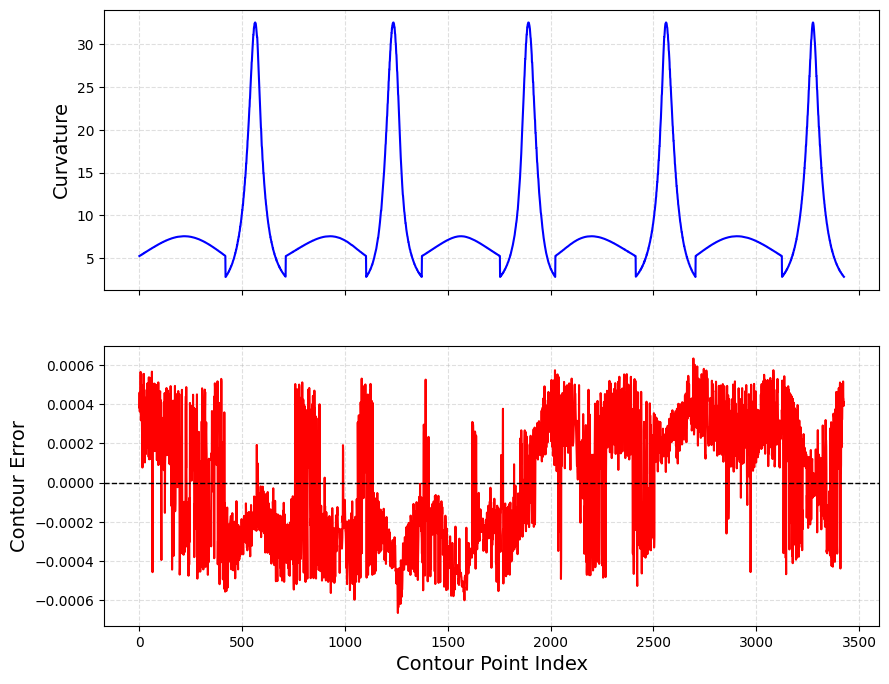

In [16]:
#plot curvature and contour error together below eachother
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
ax1.plot(curvatures_sorted.numpy(), color='blue')
ax1.set_ylabel('Curvature', fontsize=14)
ax2.plot(contour_error_sorted.numpy(), color='red')
ax1.grid(True, which="both", linestyle="--", alpha=0.4)
#also plot a horizontal line at y=0
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.set_ylabel('Contour Error', fontsize=14)
ax2.set_xlabel('Contour Point Index', fontsize=14)
ax2.grid(True, which="both", linestyle="--", alpha=0.4)


NameError: name 'curvatures_2' is not defined

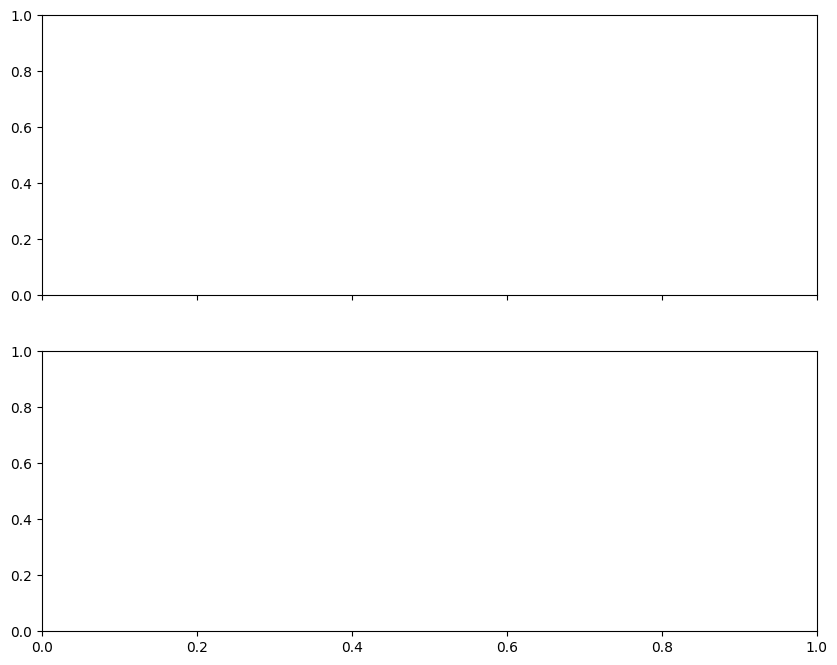

In [15]:
#GT
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
ax1.plot(curvatures_2.numpy(), color='blue')
ax1.set_ylabel('Curvature', fontsize=14)
ax2.plot(contour_error_sorted2.numpy(), color='red')
ax1.grid(True, which="both", linestyle="--", alpha=0.4)
#also plot a horizontal line at y=0
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.set_ylabel('Contour Error', fontsize=14)
ax2.set_xlabel('Contour Point Index', fontsize=14)
ax2.grid(True, which="both", linestyle="--", alpha=0.4)


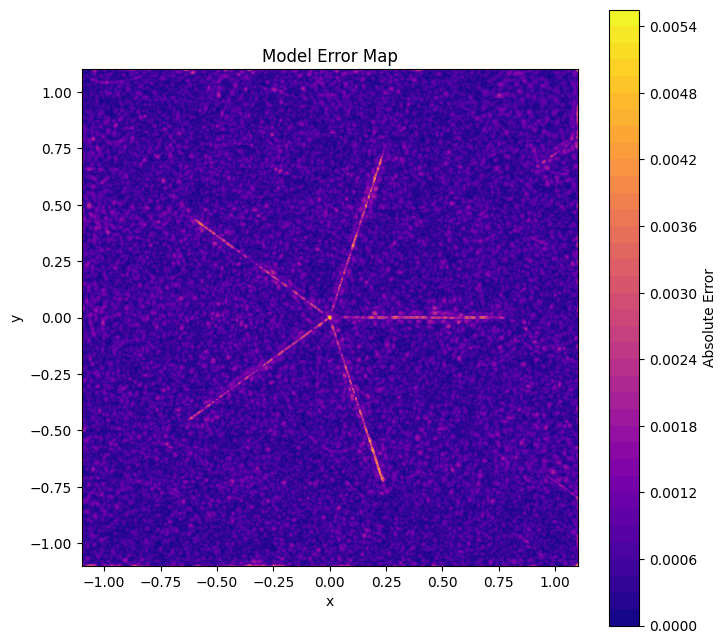

In [17]:
#plot_model_error_heatmap
geom_vis.plot_model_error_map(model2, rounded_star_cp, degree=DEGREE, N=500, use_log=False,num_curve_samples=6000)

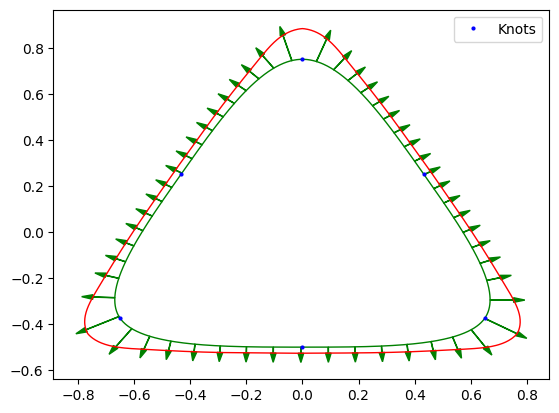

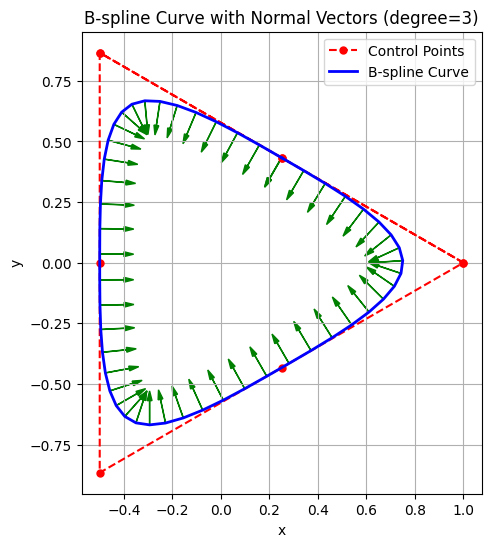

In [23]:
# plot curvature onto the contour plot
# ------------------------------------------------------------

fig, ax = plt.subplots()
#ax.contourf(X, Y, Z, levels=50, cmap='RdBu_r')
magnitude = 0.01

normal_vec = bsp_geom.bspline_normalvectors(t=t_values_sorted, control_points=rounded_star_cp,knots=bsp_geom.create_knot_vector(rounded_star_cp.shape[0], degree=3, closed=True), degree=3)
new_point = np.zeros_like(contours_t.numpy())

tmp = bsp_geom.evaluate_bspline_curve_vectorized(t_values_sorted, rounded_star_cp, bsp_geom.create_knot_vector(rounded_star_cp.shape[0], 3, closed=True), degree=3)
ax.plot(tmp[:,1] , tmp[:,0] , 'g-',  linewidth=1)

for i in range(len(contours_t)):
    err = curvatures_sorted[i].numpy()
    new_point[i] = tmp[i] - normal_vec[i].numpy()*magnitude*err
    if i % 50 == 0:
        start = tmp[i].numpy()
        ax.arrow(start[1], start[0], -normal_vec[i, 1].numpy()*err*magnitude, -normal_vec[i, 0].numpy()*err*magnitude,
                  head_width=0.02, head_length=0.04, fc='g', ec='g')
               
ax.plot(new_point[:,1] , new_point[:,0] , 'r-',  linewidth=1)

#also mark the knots
knots = bsp_geom.create_knot_vector(len(rounded_star_cp), degree=3, closed=True)
knot_points = bsp_geom.evaluate_bspline_curve_vectorized(knots, rounded_star_cp, knots, degree=3)[3:-3-1]
ax.plot(knot_points[:,1], knot_points[:,0], 'bo', markersize=2, label='Knots')
ax.legend()

geom_vis.plot_normal_vectors_on_bspline(rounded_star_cp, degree=3, num_vectors=50, vector_length=0.1)
    



plt.show()



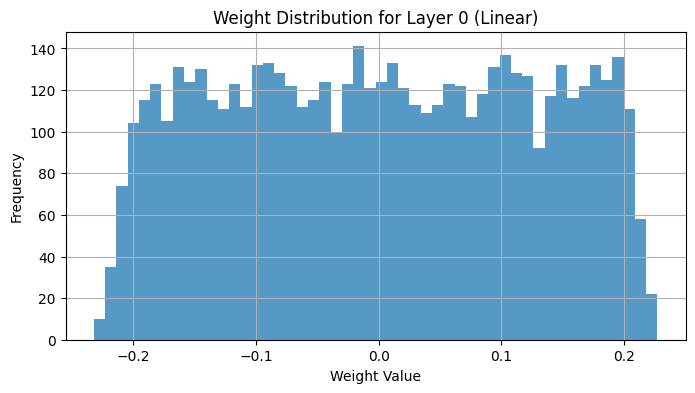

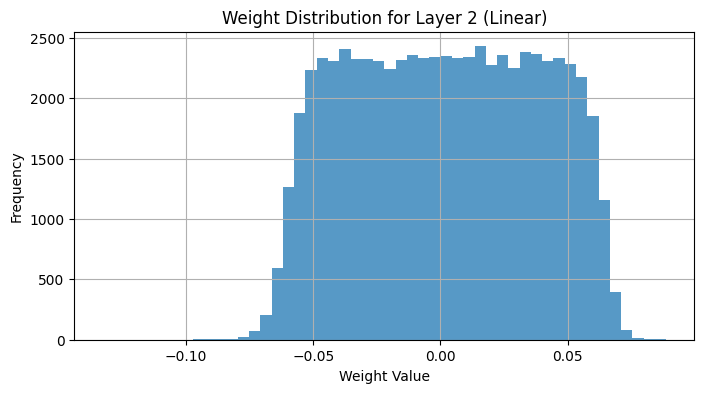

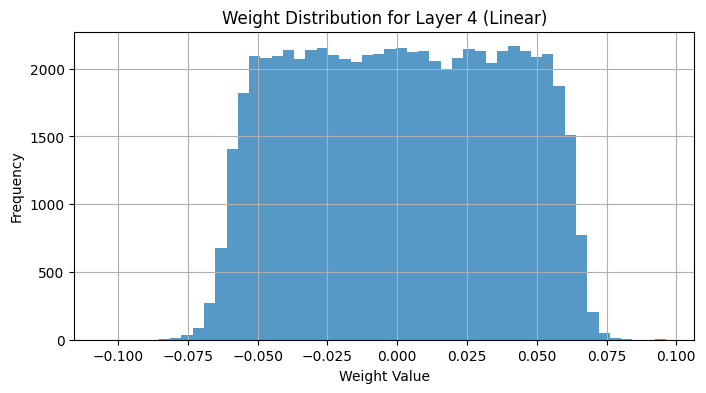

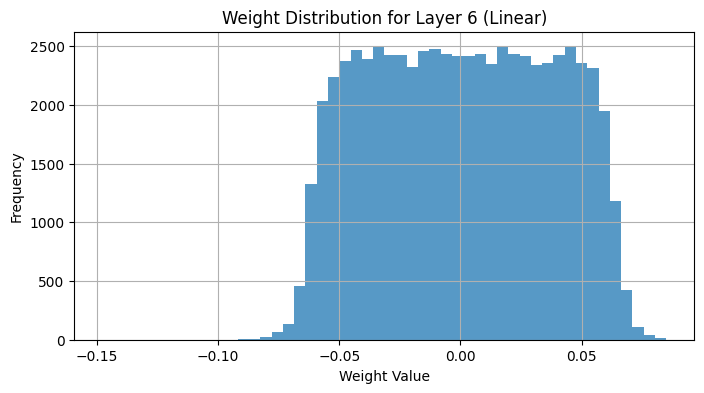

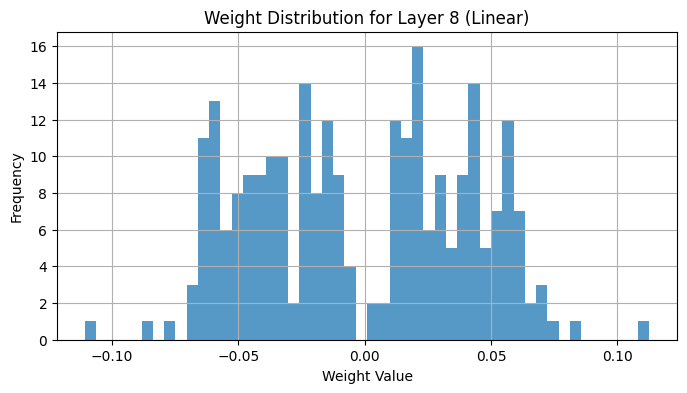

In [18]:
NI.plot_model_weight_per_layer_hyst(model2)

In [8]:
def train_model_old(model,num_epochs=10):
    report_interval = num_epochs // 10
    criterion = nn.MSELoss()
    cntrl_pts = bsp_geom.create_polygon_bspline_control_points(5,degree=1)
    knots = bsp_geom.create_knot_vector(len(cntrl_pts), degree=1)
    for epoch in range(num_epochs):
        pts = torch.randn((500,2))*2-1
        #pts = pts.clone().detach().requires_grad_(True)
        pred = model(pts)
        target = bsp_geom.bspline_signed_distance_vectorized(pts,cntrl_pts,degree=1)
        loss_sdf = criterion(pred.squeeze(), target)
        loss = loss_sdf
        model.optimizer.zero_grad()
        loss.backward()
        model.optimizer.step()
        #model.lr_scheduler.step()
        model.loss_history.append(loss.item())
        if epoch % report_interval == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
train_model_old(model,100)

Epoch 0, Loss: 4.556866
Epoch 10, Loss: 3.761360
Epoch 20, Loss: 3.181367
Epoch 30, Loss: 2.467447
Epoch 40, Loss: 2.155694
Epoch 50, Loss: 2.265133
Epoch 60, Loss: 1.921426
Epoch 70, Loss: 1.436932
Epoch 80, Loss: 1.295657
Epoch 90, Loss: 1.372169
